In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
pd.options.mode.copy_on_write = True

## Build a tax-benefit model from scratch in 30 minutes
 
Things we need:

* data - Family Resources Survey(FRS)/LFS/Living Costs and Food Survey(LCF)/Understanding Society... This example uses our old LCF
* A programming language:
   - We will use Python
* Structures: we need to model:
   - people, families and households;
   - the fiscal system (taxes, benefits);
   - outcomes: incomes net of taxes and benefits, revenues raised, inequalities, poverty and so on.

Let's build one from scratch, in real time (with some 'here's some I prepared earlier' where needs be).


In [44]:
url = "https://virtual-worlds.scot/ou/uk-lcf-subset-2005-6.csv"
storage_options = {'User-Agent': 'Mozilla/9.0'}

lcf = pd.read_csv(url,storage_options=storage_options)
#print(lcf.info) 
lcf_small = lcf.iloc[:10]

## Our Tax-Benefit System
This is deliberately very simple. In the first instance, we want to model how a single household is affected by one tax-benefit system. We then build up from that.

We need:

* something to describe the tax-benefit system;
* something to hold results; 
* a description of a single household; and 
* a function that takes a single household and a system and returns a result      

### Something to describe the tax-benefit system

In [45]:
# holder for 1 tax system

class System: 
     
    # Class Variable 
    system = 'System'           
     
    # The init method or constructor 
    def __init__(self, allowance, it_rate, ni_rate, benefit, vat_rate, extend_vat): 
     
        # Instance Variable     
        self.allowance = allowance
        self.it_rate = it_rate    
        self.ni_rate = ni_rate
        self.benefit = benefit
        self.vat_rate = vat_rate
        self.extend_vat = extend_vat

### Something to hold results

In [46]:
# holder for 1 Result

class Result: 
     
    # Class Variable 
    result = 'Result'           
     
    # The init method or constructor 
    def __init__(self, net, tax, ni, vat, benefit): 
     
        # Instance Variable     
        self.net = net
        self.tax = tax
        self.ni = ni
        self.vat = vat
        self.benefit = benefit

### A description of a single household
A single household is represented by a row in the lcf dataset we downloadaed above

### A function that takes a single household and a system and returns a result

In [47]:
# calculate for one household and one system, returning one result
def calc_system( hh, sys):
    out = Result
    #print("out tax is ", out.tax)
    taxable = max(0.0, hh.hhincome-sys.allowance )
    out.tax = taxable*sys.it_rate
    out.ni = max(0.0, hh.gross_pay*sys.ni_rate)
    out.benefit = 0.0 
    # an unemployment/retirement benefit
    if hh.number_in_work == 0:
        out.benefit = sys.benefit
    vatable = hh.tobacco_alcohol + hh.clothing + hh.housing_and_energy + hh.household_goods + hh.health + hh.transport + hh.communication + hh.recreation +	hh.restaurants_etc + hh.misc_goods
    if sys.extend_vat:
        vatable += hh.food_and_drink + hh.housing_and_energy+hh.education
    out.vat = vatable * sys.vat_rate
    out.net = hh.hhincome - out.ni - out.tax - out.vat + out.benefit
    return out

## Create some variables for the dynamic tax and benefit system

Below we create some interactive variables so that a second tax and benefit system can be used and modified to compare with our original one

In [48]:
new_allowance = widgets.BoundedFloatText(
    value=10000,
    min=0,
    max=25000,
    step=200,
    description='Tax Allowance (pa):',
    disabled=False
)

new_it_rate = widgets.BoundedFloatText(
    value=25,
    min=0,
    max=75,
    step=1,
    description='Income Tax Rate (%):',
    disabled=False
)

new_ni_rate = widgets.BoundedFloatText(
    value=10,
    min=0,
    max=75,
    step=1,
    description='Payroll Tax (NI) (%):',
    disabled=False
)

new_benefit = widgets.BoundedFloatText(
    value=10,
    min=0,
    max=250,
    step=5,
    description='Benefit Rate (p.w):',
    disabled=False
)

new_vat_rate = widgets.BoundedFloatText(
    value=20,
    min=0,
    max=75,
    step=1,
    description='VAT (%):',
    disabled=False
)

new_extend_vat = widgets.Checkbox(
    value=False,
    description='Extend VAT?',
    disabled=False,
    indent=True
)

In [365]:
new_allowance
new_it_rate
new_ni_rate
new_benefit
new_vat_rate
new_extend_vat

BoundedFloatText(value=10000.0, description='Tax Allowance (pa):', max=25000.0, step=200.0)

BoundedFloatText(value=25.0, description='Income Tax Rate (%):', max=75.0, step=1.0)

BoundedFloatText(value=10.0, description='Payroll Tax (NI) (%):', max=75.0, step=1.0)

BoundedFloatText(value=250.0, description='Benefit Rate (p.w):', max=250.0, step=5.0)

BoundedFloatText(value=20.0, description='VAT (%):', max=75.0, step=1.0)

Checkbox(value=False, description='Extend VAT?')

## Initialise Systems

These construct our two tax-benefit systems. So `sys1` has a 10k tax allowance, and so on. Sys2, the changed system, is set from a bunch of variables we set above: `new_allowance` and so on. This allows us to change the parameters dynamically.

In [366]:
sys1 = System( 10_000/52, 0.25, 0.10, 100.0, 0.20, False )
sys2 = System( new_allowance.value/52, new_it_rate.value/100, new_ni_rate.value/100, new_benefit.value, new_vat_rate.value/100, new_extend_vat )

## Sample Weights

Some very crude stuff to uprate and weight our very old LCF data. 

* We use a single household weight which is just [the number of households in the UK from the ONS](https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/abmz/ukea) divided by the number of sample housholds.
* We uprate by the [change in Nominal GDP between 2005 Q3 and 2023 Q3](https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/abmz/ukea).

In [368]:
SAMPLE_SIZE = lcf_small.shape[0] # count of rows
NUM_HHLDS = 24_783_192
WEIGHT = 1 #NUM_HHLDS/SAMPLE_SIZE
	# https://www.ons.gov.uk/economy/grossdomesticproductgdp/timeseries/abmz/ukea
INFLATION = 678129/353999
	## nom gdp q3 2004 332192 q3 2023 678129

lcf.loc[:,
    ["hhincome",
        "gross_pay",
        "food_and_drink",
        "tobacco_alcohol",
        "clothing",
        "housing_and_energy",
        "household_goods",
        "health",
        "transport",
        "communication",
        "recreation",
        "education",
        "restaurants_etc",
        "misc_goods",
        "total_consumption",
        "non_consumption",
        "total_expenditure"]] *= INFLATION

## Run the model over each household

Next, run our single household/single system function for each household in the data. To save the results, we construct a new DataFrame to hold vectors of tax payments, etc., and fill that in as we go along. We run this function twice, once foreach system, and pass the result DataFrames to the analysis function, which summarises everything for us. 

In [369]:
def one_calc(sys):
    n = lcf_small.shape[0] # count of rows
    # create DF with zeroes to hold the results
    out = pd.DataFrame(
        np.zeros((n, 6)), columns=["gross", "net", "tax", "ni", "vat", "benefit"]
    )
    #print(out.info)
    # Iterating over rows
    
    for i in range(0,n):
        res = calc_system( lcf_small.iloc[i], sys )
        out.loc[i,"gross"] = lcf_small.iloc[i].hhincome
        out.loc[i,"net"] = res.net
        out.loc[i,"tax"] = res.tax
        out.loc[i,"ni"] = res.ni
        out.loc[i,"vat"] = res.vat
        out.loc[i,"benefit"] = res.benefit

    out["weight"] = WEIGHT  # adding the weight constant to every result for use later

    return out
        


In [370]:
res1 = one_calc(sys1)
#print (res1.info)
res2 = one_calc(sys2)


In [371]:
print(res1)
print(res2)

         gross          net          tax          ni          vat  benefit  \
0  5155.089627  2503.313661  1240.695484  569.650971   841.429512      0.0   
1   927.570276   738.078597   183.815646    0.000000   105.676033    100.0   
2  2750.473066  1415.261586   639.541343    0.000000   695.670137      0.0   
3  5323.195571  3444.423325  1282.721970    0.000000   696.050276    100.0   
4  3022.237548  1215.785494   707.482464  175.810390   923.159200      0.0   
5  1028.360735   766.791013   209.013261    0.000000   152.556461    100.0   
6  5843.287836  3510.423904  1412.745036  483.158726   436.960170      0.0   
7  3066.242867   798.933505   718.483794  508.767573  1040.057996      0.0   
8  9659.659721  6745.967748  2366.838007  110.463194   436.390772      0.0   
9  4030.437379  2862.691980   959.532422    0.000000   308.212977    100.0   

   weight  
0       1  
1       1  
2       1  
3       1  
4       1  
5       1  
6       1  
7       1  
8       1  
9       1  
         

## Analyse And Display The Results

At the other end of the process, we'll have lists of results, one per household, possibly for 2 or more of our tax systems. We'll need to summarise and compare them. The next two functions do this. There's some messy detail here, especially for the charts. We use the `PoveryAndInequalityMeasures` package to produce deciles and Lorenz curves.


In [372]:
def make_gini_palma(data):
    #print(data)
    lorenz = 0.0
    nrows = data.shape[0] # count of rows
    if nrows == 0:
        return 0.0
    #sort by income
    sorted_data = data.sort_values(by='net').reset_index(drop=True)
    sorted_data.loc[0,"POPN_ACCUM"] = WEIGHT
    sorted_data.loc[0, "INCOME_ACCUM"] = sorted_data.loc[0, "net"]*WEIGHT
    sorted_data.loc[0, "WEIGHTED_INCOME"] = sorted_data.loc[0, "net"]*WEIGHT
    #print(sorted_data)
    for i in range(1,nrows):
        #print(i)
        sorted_data.loc[i,"POPN_ACCUM"] = sorted_data.loc[i-1,"POPN_ACCUM"] + WEIGHT
        sorted_data.loc[i, "INCOME_ACCUM"] = sorted_data.loc[i-1, "INCOME_ACCUM"] + sorted_data.loc[i, "net"]*WEIGHT
        sorted_data.loc[i, "WEIGHTED_INCOME"] = sorted_data.loc[i, "net"]*WEIGHT
    #print(sorted_data)

    for i in range(1,nrows):
        lorenz += sorted_data.loc[i, "weight"]*((2.0*sorted_data.loc[i,"INCOME_ACCUM"]) - sorted_data.loc[i,"WEIGHTED_INCOME"])
    #print(lorenz)
    lastr = sorted_data.iloc[-1:] # last entry
    #print(lastr)
    gini=float(1.0-(lorenz/lastr["INCOME_ACCUM"])/lastr["POPN_ACCUM"])
    #print(gini)

    sorted_data['bins'] = pd.cut(x=sorted_data['POPN_ACCUM'],bins=10)
    #print(sorted_data)
    accumulated_income_per_decile = sorted_data.groupby(['bins'], observed=False)['INCOME_ACCUM'].agg(['max'])
    income_per_decile = (sorted_data.groupby(['bins'],observed=False)['net'].agg(['sum']))* WEIGHT
    average_income_per_decile = income_per_decile / WEIGHT # in other words income divided by the population of that decile
    #print(income_per_decile, accumulated_income_per_decile, average_income_per_decile)
    #print(accumulated_income_per_decile.iloc[3])
    #print(income_per_decile.iloc[9])
    palma = float(income_per_decile.iloc[9]) / float(accumulated_income_per_decile.iloc[3])
    #print(palma)

    retval = { "gini":gini , "palma":palma, "average_income_per_decile": average_income_per_decile}
    return retval

#EXPLAINER
# to make_gini you have to
# take initial dataframe (res)
# first sort data by income
# loop over the rows.. add a POPN_ACCUM field which the sum of households (this is adding the weight.. in our case that is a constant but in a more realistic model weights would be different) 
# and add a field INCOME_ACCUM with the sum of income up to that point (net * weight)
# (so basically in the last row you end up with the total population and the total income
# Add another field WEIGHTED_INCOME, which is hh income * weight 
# Then run the below make gini 
# It produces one number that is returned
# test: if all the nets are the same, then the Gini should be zero
    # if all the nets are zero except the last one, then gini = 1 

# to make_palma you have to:
# take the augmented data
# chop it into 10 bins (equal ones... in this case that works because the weights are the same)
# we need the total income in each decile and the cumulative income at that point 
# We want the cumulative income at decile four (i.e. how much income does the bottom 40% have)
# We want to know the income of the 10th decile
# The palma index is 10th decile share of income / share of income of the bottom 40%
# test: if all the nets are 1 (or the same) then the palma should be 1/4

In [394]:
# # res1 and res2 are DataFrames holding lists of results for a pre- and post- system run. See the next cells for more.

def analyse( res1, res2):

    #print(res1, res2)
    cols = ['tax', 'ni','vat']
    tax1 = res1[cols].sum(axis=1)*52*WEIGHT
    #print(tax1)
    #print(res2)
    tax2 = res2[cols].sum(axis=1)*52*WEIGHT
    #print(tax2)
    ben1 = res1.benefit*52*WEIGHT
    #print("ben1 is", ben1)
    ben2 = res2.benefit*52*WEIGHT
    #print("ben 2 is", ben2)
    dben = ben2-ben1
    #print("dben is ", dben)
    dtax = tax2-tax1
    #print("dtax is", dtax)
    ineq1 = make_gini_palma(res1)
    ineq2 = make_gini_palma(res2)
    dgini = ineq2["gini"] - ineq1["gini"]
    dpalma = ineq2["palma"] - ineq1["palma"]
    #print("digini is ", dgini)
    #print("dpalma is ", dpalma)

    gainers = res2[(res2['net'] > res1['net'])]['net'].count()
    losers = res2[(res2['net'] < res1['net'])]['net'].count()
    nc = res2[(res2['net'] == res1['net'])]['net'].count()

    #print("gainers is ", gainers)
    #print("losers is ", losers)
    #print("nc is ", nc)

    ### now plot
    n = res1.shape[0]  # number of rows
    ninc1 = res1['net'].sum()
    ninc2 = res2['net'].sum()

    #sort by income
    sorted_data1 = res1.sort_values(by='net').reset_index(drop=True)
    sorted_data2 = res2.sort_values(by='net').reset_index(drop=True)

    x=np.cumsum([1]*n)/n
    #print("x is", x)
    y= np.cumsum(sorted_data1['net'])/ninc1
    #print("y is ", y)
    y1 = np.cumsum(sorted_data2['net'])/ninc2
    x2=[0,1]
    y2=[0,1]
    plt.plot(x, y,'r-',label='Initial T&B System')
    plt.plot(x, y1,'b-',label='Modified T&B System')
    plt.plot(x2, y2, 'g-',label='Perfect Equality')
    plt.title('Lorenz Curve')
    plt.xlabel('Income Share')
    plt.ylabel('Population Share')
    plt.grid()
    plt.legend()
    plt.show()


    #x xis deciles
    x3 = [1,2,3,4,5,6,7,8,9,10]
    
    #y is gain/loss
    y3 = ineq2['average_income_per_decile'] - ineq1['average_income_per_decile']
    #print(y3['sum'])
    plt.bar(x3,y3['sum'])
    plt.title('Gains/Losses By Decile')
    plt.xlabel('Decile')
    plt.ylabel('£s pw')
    plt.show()


    print(
        "Tax Revenue before:", tax1.sum()
    )
    # gainers = sum(res1[res2.net .> res1.net,:weight])  #basicall summing who comes out on top v who comes out worse off (in number of households)
    # losers = sum(res1[res2.net .< res1.net,:weight])
    # nc = sum(res1[res2.net .== res1.net,:weight])

    # gain = ineq2.deciles[:,4] .- ineq1.deciles[:,4]  ## this is 10 numbers of the average income per decile 
    #(sum of incomes in that decile* weight / the number of people in that decile * weight)
    # plot that as a bar chart
    # f = Figure()
    # ax1 = Axis(f[1,1], 
    #     title="Gains/Losses By Decile", 
    #     xlabel="Decile", 
    #     ylabel="£s pw" )
    # deciles = barplot!( ax1, gain )

    # i1 = copy(ineq1.deciles[:,1:2])
    # i1 = vcat([0.0 0.0],i1)
    # i2 = copy(ineq2.deciles[:,1:2])
    # i2= vcat([0.0 0.0],i2)		
    # ax2 = Axis(f[2,1];
    #     limits=((0.0,1.0),(0,1.0)),
    #     title="Lorenz Curve", 
    #     xlabel="population share", 
    #     ylabel="Income Share" )
    # lines!(ax2, i1[:,1],i1[:,2], label="Before" )
    # lines!(ax2, i2[:,1],i2[:,2], label="After" )
    # lines!(ax2, 0:1, 0:1; color=:lightgrey, label="Equality" )
    # Legend( f[2,2], ax2, "", framevisible = false)
    # (; 
    #  chart = f,
    #  ben1 = fm( ben1 ),
    #  ben2 = fm( ben2 ),
    #  dben = fm(dben),
    #  gini1=fp(ineq1.gini), 
    #  gini2=fp(ineq2.gini),
    #  palma1=fp(ineq1.palma),
    #  palma2=fp(ineq2.palma),
    #  dpalma=fp(dpalma),
    #  dgini=fp(dgini),
    #  tax1=fm( tax1 ),
    #  tax2=fm( tax2 ),
    #  dtax=fm( dtax ),
    #  gainers=fc( gainers ),
    #  losers=fc( losers ),
    #  nc=fc(nc))


/tmp/ipykernel_9890/2016433527.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gini=float(1.0-(lorenz/lastr["INCOME_ACCUM"])/lastr["POPN_ACCUM"])
/tmp/ipykernel_9890/2016433527.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  palma = float(income_per_decile.iloc[9]) / float(accumulated_income_per_decile.iloc[3])
/tmp/ipykernel_9890/2016433527.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gini=float(1.0-(lorenz/lastr["INCOME_ACCUM"])/lastr["POPN_ACCUM"])
/tmp/ipykernel_9890/2016433527.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  palma = float(income_per_decile.iloc[9]) / flo

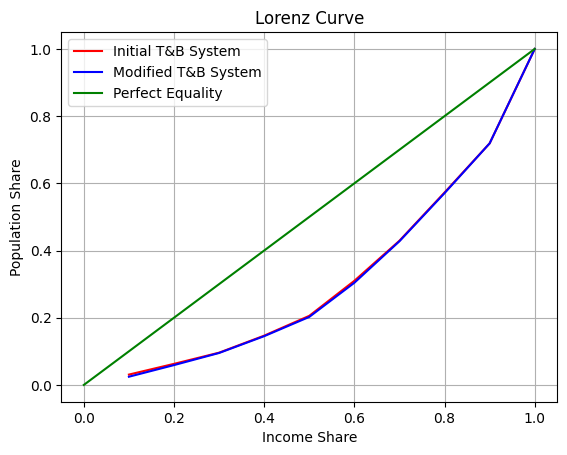

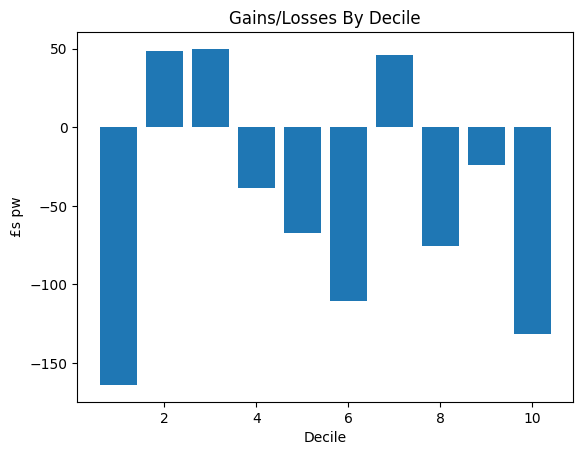

Tax Revenue before: 894653.9583666981


In [395]:
analyse(res1, res2)

s